# 1.多层感知机的从零开始实现

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [2]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens, requires_grad=True))
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs, requires_grad=True))
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

In [3]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

In [4]:
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X @ W1 + b1)
    return (H @ W2 + b2)

loss = nn.CrossEntropyLoss()

train_info: (0.009353974332412083, 0.7521666666666667)
test_info: 0.7115
(0.009353974332412083, 0.7521666666666667, 0.7115)
train_info: (0.006199714843432108, 0.7614666666666666)
test_info: 0.7467
(0.006199714843432108, 0.7614666666666666, 0.7467)
train_info: (0.004941599144538244, 0.77085)
test_info: 0.7313
(0.004941599144538244, 0.77085, 0.7313)
train_info: (0.004242840135097504, 0.7774)
test_info: 0.7465
(0.004242840135097504, 0.7774, 0.7465)
train_info: (0.00378022021651268, 0.7842166666666667)
test_info: 0.7592
(0.00378022021651268, 0.7842166666666667, 0.7592)
train_info: (0.003474794687827428, 0.7884333333333333)
test_info: 0.7654
(0.003474794687827428, 0.7884333333333333, 0.7654)
train_info: (0.0032257575273513792, 0.7917)
test_info: 0.7379
(0.0032257575273513792, 0.7917, 0.7379)
train_info: (0.0030385625178615252, 0.7964333333333333)
test_info: 0.7693
(0.0030385625178615252, 0.7964333333333333, 0.7693)
train_info: (0.0028864617183804514, 0.8010666666666667)
test_info: 0.7708
(0

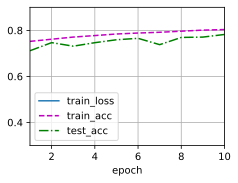

In [8]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        # display.display(self.fig)
        # display.clear_output(wait=True)

def train_epoch_ch3(net, train_iter, loss, updater):
    """训练模型一个迭代周期"""
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用torch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """训练模型"""
    animator = Animator(xlabel="epoch", xlim=[1, num_epochs], ylim=[0.3,0.9],
                        legend=["train_loss", "train_acc", "test_acc"])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        print("train_info:",train_metrics)
        test_acc = evaluate_accuracy(net, test_iter)
        print("test_info:",test_acc)
        print(train_metrics+(test_acc,))
        animator.add(epoch+1, train_metrics+(test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

# 2、多层感知机的简洁实现

In [9]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 256), nn.ReLU(),
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

train_info: (0.009021625379721324, 0.1)
test_info: 0.1
(0.009021625379721324, 0.1, 0.1)


KeyboardInterrupt: 

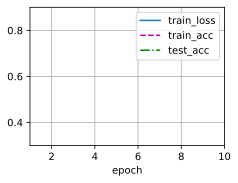

In [11]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=lr)

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)